In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import shap

RANDOM_STATE = 599

In [118]:
df = pd.read_csv('Data in Table S6 of the Supporting Information.csv')

In [119]:
print(df.shape)
df.head()

(35, 15)


,atom_N,Radii,chemi_pot,out_e,i1,electron affinity (kJ/mol),badar charge (e),binding energy (eV),formation energy (eV),fermi level (eV),bandgap (eV),DG1 (eV),DG2 (eV),DG3 (eV),DG4 (eV)
0,13,118,-3.746,3,577.5,42.5,-2.332755,-11.151641,-0.013,-3.3505,0.825,-3.275531,-0.847983,1.236200,3.098314
1,5,87,-6.091,3,800.6,26.7,-2.066044,-14.612890,-2.414,-3.6775,1.091,-1.877867,2.366866,-1.713177,1.435178
2,14,111,-5.425,4,786.5,133.6,-2.770533,-13.097510,-0.370,-3.4200,0.998,-2.435926,0.225297,-0.057994,2.479623
3,3,167,-1.907,1,520.2,59.6,-0.882330,-5.356421,0.199,-3.1648,0.619,-1.975295,2.827400,-2.751293,2.110188
4,8,48,-4.485,6,1313.9,141.0,0.969135,-8.677571,-0.935,-2.5859,1.030,-2.031507,2.422484,-1.767571,1.587594


In [120]:
data = df.values

X = data[:, :11]
Y = data[:, 11:]
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, random_state = RANDOM_STATE)



In [121]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

x_train_df = pd.DataFrame(x_train)
y_train_df = pd.DataFrame(y_train)
x_train_df.head()

(28, 11)
(7, 11)
(28, 4)
(7, 4)


,0,1,2,3,4,5,6,7,8,9,10
0,5.0,87.0,-6.091,3.0,800.6,26.7,-2.069322,-13.013210,-2.118,-3.5177,0.903
1,17.0,79.0,-1.465,7.0,1251.2,349.0,0.436571,-0.880378,-1.463,-4.8034,1.698
2,5.0,87.0,-6.091,3.0,800.6,26.7,-1.658133,-11.119823,-0.220,-3.4556,0.791
3,28.0,149.0,-5.567,10.0,737.1,112.0,-0.741870,-3.845998,-0.541,-2.7283,0.674
4,14.0,111.0,-5.425,4.0,786.5,133.6,-2.770533,-13.097510,-0.370,-3.4200,0.998


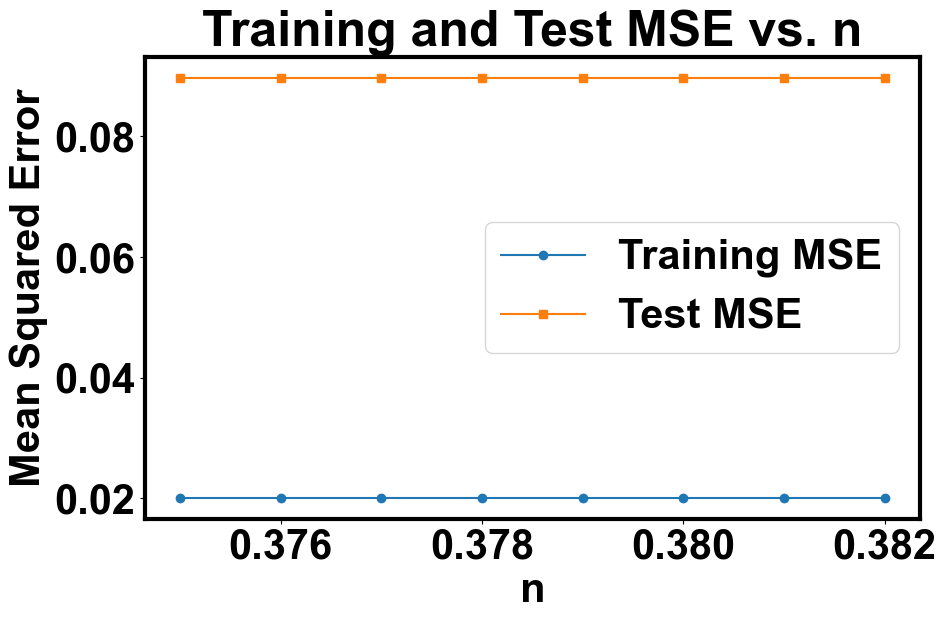

                       feature  importance
3                        out_e    0.357913
7          binding energy (eV)    0.154715
0                       atom_N    0.130551
1                        Radii    0.087272
10                bandgap (eV)    0.078726
9             fermi level (eV)    0.067264
8        formation energy (eV)    0.039796
4                          i1     0.033108
6             badar charge (e)    0.024442
2                    chemi_pot    0.022005
5   electron affinity (kJ/mol)    0.004209


In [122]:
n_range = np.arange(0.375, 0.382, 0.001)
train_mse_scores = []
test_mse_scores = []

for n in n_range:
    model = XGBRegressor(
        n_estimators=7,
        learning_rate=0.586,
        verbosity=1,
        random_state=RANDOM_STATE,
        reg_alpha=0,
        reg_lambda=1,
        max_depth=8,
        min_child_weight=3,
        gamma=0
    )
    model.fit(x_train, y_train)
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)
    train_mse = mean_squared_error(y_train, train_predictions)
    test_mse = mean_squared_error(y_test, test_predictions)
    train_mse_scores.append(train_mse)
    test_mse_scores.append(test_mse)

plt.figure(figsize=(10, 6))
plt.plot(n_range, train_mse_scores, marker='o', label='Training MSE')
plt.plot(n_range, test_mse_scores, marker='s', label='Test MSE')
plt.xlabel('n')
plt.ylabel('Mean Squared Error')
plt.title('Training and Test MSE vs. n')
plt.legend()
plt.show()

importances = model.feature_importances_

feature_names = df.columns[:11]
feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importances})

feature_importances.sort_values(by='importance', ascending=False, inplace=True)

print(feature_importances)

In [123]:
print(
    f"Metrics train:\n"
    f"\t MSR: {mean_squared_error(y_train, train_predictions):.4f} \n"
    f"\t MAR: {mean_absolute_error(y_train, train_predictions):.4f} \n"
    f"\t R2: {r2_score(y_train, train_predictions):.4f}"
)

print(
    f"Metrics test:\n"
    f"\t MSR: {mean_squared_error(y_test, test_predictions):.4f} \n"
    f"\t MAR: {mean_absolute_error(y_test, test_predictions):.4f} \n"
    f"\t R2: {r2_score(y_test, test_predictions):.4f}"
)

Metrics train:
	 MSR: 0.0201 
	 MAR: 0.0852 
	 R2: 0.9822
Metrics test:
	 MSR: 0.0897 
	 MAR: 0.2080 
	 R2: 0.9349


y_test:
0.1833992 -0.9639731 -0.8643401 1.855914
-1.1996728 0.3946019 0.7062999 0.309771
-0.3106448 -0.1273721 0.8037749 -0.154758
0.2616552 -1.3958221 1.7536669 -0.4085
0.2903862 -1.4525181 2.0043999 -0.631268
-1.8778668 2.3668659 -1.7131771 1.435178
0.1418092 0.0589219 -1.2819721 1.292241
test_predictions:
-0.20779128 -0.35518092 -0.8256922 1.3928403
-1.2248738 0.22314155 1.123571 0.3002851
-0.24348977 -0.051258635 0.9045854 -0.20452587
0.34643078 -1.2848305 1.7188516 -0.48363948
0.23967996 -0.82643884 1.1807666 -0.53456277
-1.8057169 1.9515764 -1.3131735 1.4829632
0.002031792 0.1863655 -1.0417882 1.2319919
y_train:
-1.5354418 2.2511439 -1.6232791 1.118577
0.2691722 -1.3912971 1.6930709 -0.359946
-1.3088428 0.3318529 0.0141299 1.17386
-0.0849068 0.0993459 -1.0288611 1.225422
-2.4359258 0.2252969 -0.0579941 2.479623
-0.5412408 0.4563829 0.1384129 0.157445
0.0340962 1.5646939 -0.8904931 -0.497297
0.2302822 -0.8061951 1.3665529 -0.57964
-0.4333458 0.4320139 -0.8995601 1.111892
-0.070022

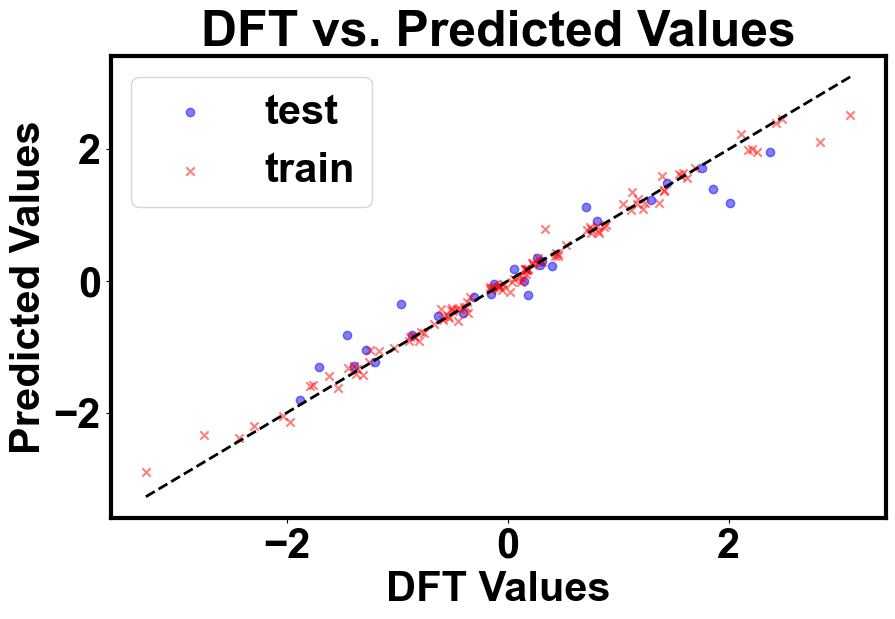

In [124]:
def print_no_brackets(array):
    for item in array:
        print(' '.join(map(str, item)))

print("y_test:")
print_no_brackets(y_test)

print("test_predictions:")
print_no_brackets(test_predictions)

print("y_train:")
print_no_brackets(y_train)

print("train_predictions:")
print_no_brackets(train_predictions)

plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5, color='blue', label='test', marker='o')
plt.scatter(y_train, train_predictions, alpha=0.5, color='red', label='train', marker='x')

plt.xlabel("DFT Values")
plt.ylabel("Predicted Values")
plt.title("DFT vs. Predicted Values")
plt.legend()

plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
plt.show()

In [125]:
import matplotlib.pyplot as plt
import shap

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.size'] = 30

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

shap_data = {}

if isinstance(shap_values, list) and len(shap_values) == 4:
    for i in range(len(shap_values)):
        print(f"SHAP summary plot for target {i+1}")
        
       
        feature_names = [r'{}'.format(feature.replace('_', r'_\mathrm{')) + '}' if '_' in feature else feature for feature in df.columns[:11]]
else:
    print()

SHAP summary plot for target 1
SHAP summary plot for target 2
SHAP summary plot for target 3
SHAP summary plot for target 4


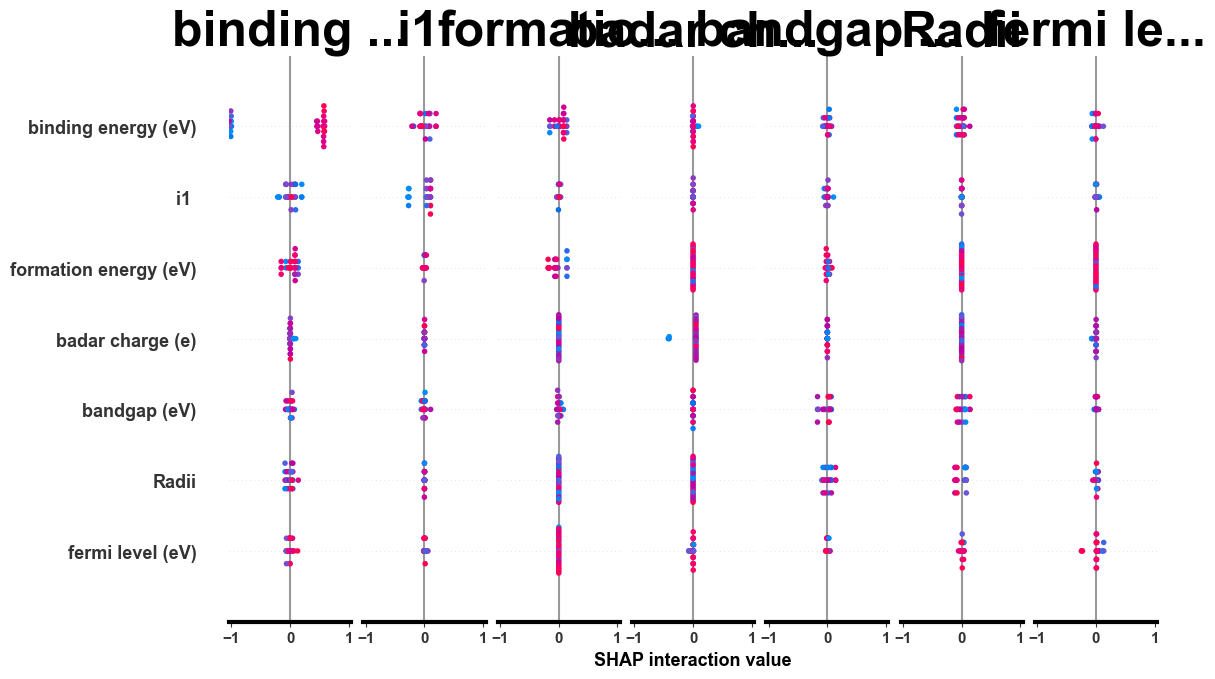

In [126]:
shap_interaction_values = explainer.shap_interaction_values(x_train)

shap.summary_plot(shap_interaction_values[0], x_train, feature_names=df.columns[:11])

In [ ]:
import matplotlib.pyplot as plt
import shap
import pandas as pd
import numpy as np

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.linewidth'] = 3 

df = pd.read_csv('Data in Table S6 of the Supporting Information.csv')  

x_train = df.iloc[1:, :11].values.astype(float)  
feature_names = df.columns[:11].tolist() 

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

for i in range(4):
    plt.figure(figsize=(12, 10)) 
    
    shap.summary_plot(
        shap_values[i],
        x_train,
        feature_names=feature_names,
        show=False,
        plot_type="dot",
        color=plt.get_cmap('RdYlBu'),
        max_display=11
    )
    
    ax = plt.gca()
    
    plt.title(f'Target {i+1} Feature Importance', 
             fontsize=14, pad=20, fontweight='bold')  
    
    plt.xlabel('SHAP Value', fontsize=14, fontweight='bold')  
    plt.ylabel('Features', fontsize=14, fontweight='bold')  
    
    ax.tick_params(axis='y', which='major', labelsize=14) 
    
    ax.tick_params(axis='x', which='major', labelsize=14)  
    
    plt.tight_layout()
    plt.savefig(f'SHAP_Target_{i+1}.png', dpi=600, bbox_inches='tight')
    plt.close()


In [ ]:
k = 35 
kf = KFold(n_splits=k, shuffle=False) 

sum_mae = 0.0  
n_terms = 0    

for train_idx, test_idx in kf.split(X):
    x_train, x_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    model = XGBRegressor(
        n_estimators=7,
        learning_rate=0.586,
        verbosity=0,  # silence model chatter
        random_state=RANDOM_STATE,
        reg_alpha=0,
        reg_lambda=1,
        max_depth=8,
        min_child_weight=3,
        gamma=0
    )
    model.fit(x_train, y_train)

    y_train_pred = model.predict(x_train)
    y_test_pred = model.predict(x_test)

    sum_mae += (mean_absolute_error(y_train, y_train_pred) + mean_absolute_error(y_test, y_test_pred))
    n_terms += 2

global_mae = sum_mae / n_terms

print(f"Global MAE: {global_mae:.4f}")